In [1]:
import torch
from mlcolvar.data import DictModule
from mlcolvar.utils.io import create_dataset_from_trajectories
from mlcolvar.utils.io import create_dataset_from_files


dataset_graph = create_dataset_from_trajectories(
    trajectories=[
        'data/r.dcd',
        'data/p.dcd'
    ],
    top=['data/r.pdb', 
         'data/p.pdb'],
    cutoff=8.0,  # Ang
    create_labels=True,
    system_selection='all and not type H',
    show_progress=False
)

datamodule_graph = DictModule(dataset_graph, lengths=[0.8, 0.2], shuffle=[1, 0])
print(datamodule_graph)


dataset_ff = create_dataset_from_files(file_names=['data/colvar_r.dat',
                                                   'data/colvar_p.dat'],
                                                   filter_args={'regex': 'd'})

datamodule_ff = DictModule(dataset_ff, lengths=[0.8, 0.2], shuffle=[1, 0])


DictModule(dataset -> DictDataset( "data_list": 1600, "z_table": [6, 9], "cutoff": 8.0, "data_type": graphs ),
		     train_loader -> DictLoader(length=0.8, batch_size=1600, shuffle=1),
		     valid_loader -> DictLoader(length=0.2, batch_size=1600, shuffle=0))
Class 0 dataframe shape:  (800, 24)
Class 1 dataframe shape:  (800, 24)

 - Loaded dataframe (1600, 24): ['time', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'd10', 'd11', 'd12', 'd13', 'd14', 'd15', 'd16', 'd17', 'd18', 'd19', 'd20', 'd21', 'walker', 'labels']
 - Descriptors (1600, 21): ['d1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'd10', 'd11', 'd12', 'd13', 'd14', 'd15', 'd16', 'd17', 'd18', 'd19', 'd20', 'd21']


In [ ]:
from mlcolvar.core.nn.graph.schnet import SchNetModel

gnn_model = SchNetModel(n_out=1,
                        cutoff=dataset_graph.metadata['cutoff'],
                        atomic_numbers=dataset_graph.metadata['z_table'],
                        n_bases=6,
                        n_layers=2,
                        n_filters=32,
                        n_hidden_channels=32
                    )

from mlcolvar.core.nn.graph.gvp import GVPModel

gnn_model = GVPModel(n_out=1,
                     cutoff=dataset_graph.metadata['cutoff'],
                     atomic_numbers=dataset_graph.metadata['z_table'],
                     drop_rate=0.1)


In [14]:
from mlcolvar.cvs.supervised.deeptda import DeepTDA

model_graph = DeepTDA(n_states=2,
                        n_cvs=1,
                        target_centers=[-7, 7],
                        target_sigmas=[0.2, 0.2],
                        model=gnn_model)

from mlcolvar.core.nn import FeedForward

ff_model = FeedForward(layers=[21, 15, 10, 1])
model_ff = DeepTDA(n_states=2,
                    n_cvs=1,
                    target_centers=[-7, 7],
                    target_sigmas=[0.2, 0.2],
                    model=ff_model)

/home/etrizio@iit.local/Bin/miniconda3/envs/graph_mlcolvar_test/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


In [ ]:
from lightning import Trainer

trainer = Trainer(
    logger=False,
    enable_checkpointing=False,
    accelerator='cuda',
    max_epochs=200,
    enable_model_summary=False
)

trainer.fit(model_graph, datamodule_graph)

In [ ]:
datamodule_graph.setup()
a = datamodule_graph.train_dataloader()
test = next(iter(a))
inp = test['data_list']

tensor([0, 0, 0, 0, 0, 0, 0])

In [ ]:
xxx = inp.get_example(0)
xxx.batch = torch.zeros(len(xxx['positions']), dtype = torch.long)
xxx

Data(edge_index=[2, 42], shifts=[42, 3], unit_shifts=[42, 3], positions=[7, 3], cell=[3, 3], node_attrs=[7, 2], graph_labels=[1, 1], n_system=[1, 1], weight=[1], batch=[7])

In [18]:
model_graph.eval()
traced_model = model_graph.to_torchscript('test.pt', method='trace')

In [ ]:
model_graph.eval()

test = inp.get_example(100)
test.batch = torch.zeros(len(test['positions']), dtype = torch.long)

print(model_graph(xxx))
print(model_graph(test))

print(traced_model(xxx))
print(traced_model(test))


loaded_model = torch.jit.load('test.pt')

print(loaded_model(xxx))
print(loaded_model(test))


tensor([[1.8528]], grad_fn=<DivBackward0>)
tensor([[-2.3465]], grad_fn=<DivBackward0>)
tensor([[1.8528]], grad_fn=<DivBackward0>)
tensor([[-2.3465]], grad_fn=<DivBackward0>)
tensor([[1.8528]], grad_fn=<DivBackward0>)
tensor([[-2.3465]], grad_fn=<DivBackward0>)


In [ ]:
trainer = Trainer(
    logger=False,
    enable_checkpointing=True,
    accelerator='cpu',
    max_epochs=5,
    enable_model_summary=False
)

trainer.fit(model_ff, datamodule_ff)

In [83]:
loader = datamodule_graph
test = next(iter(loader.train_dataloader()))['data_list']
out_graph = model_graph(test)

out_ff = model_ff(dataset_ff['data'])

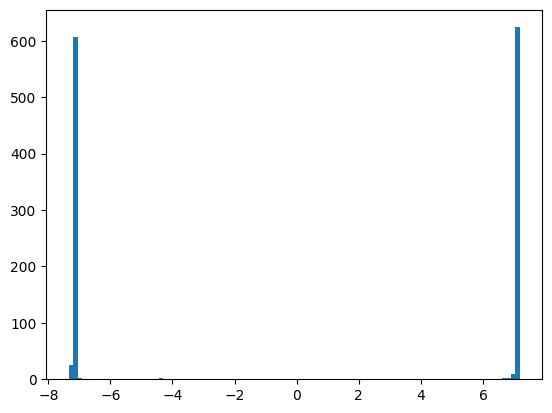

In [86]:
import matplotlib.pyplot as plt

plt.hist(out_graph.detach().squeeze(), 100)
plt.hist(out_ff.detach().squeeze())
plt.show()